# TUTORIAL: the Rijke tube model (Galerkin method) 
### Low order model of longitudinal thermocaoustic instabilities

In [1]:
import parent_folders

## 1. Define the Rijke tube low order model

#### Thermoacoustic model


In [2]:

from essentials.physical_models import Rijke
case = Rijke()

state, t_ = case.time_integrate(int(case.t_transient / case.dt))
case.update_history(state, t_)


## 2. Visualize acoustic modes

The state vector is formed of
$$
\psi = [\eta_j; \mu_j; \nu_k] \in \mathbb{R}^{2N_m+N_c},
$$
where $\eta_i, \mu_j$ are the acoustic velocity and acoustic pressure modes, with $j=1,\dots,N_m$; and $\nu_k$ are the Chebyshev modes, with $k=1,\dots,N_c$, resulting from discretizing the advection equation carrying the delayed velocity at the flame location.


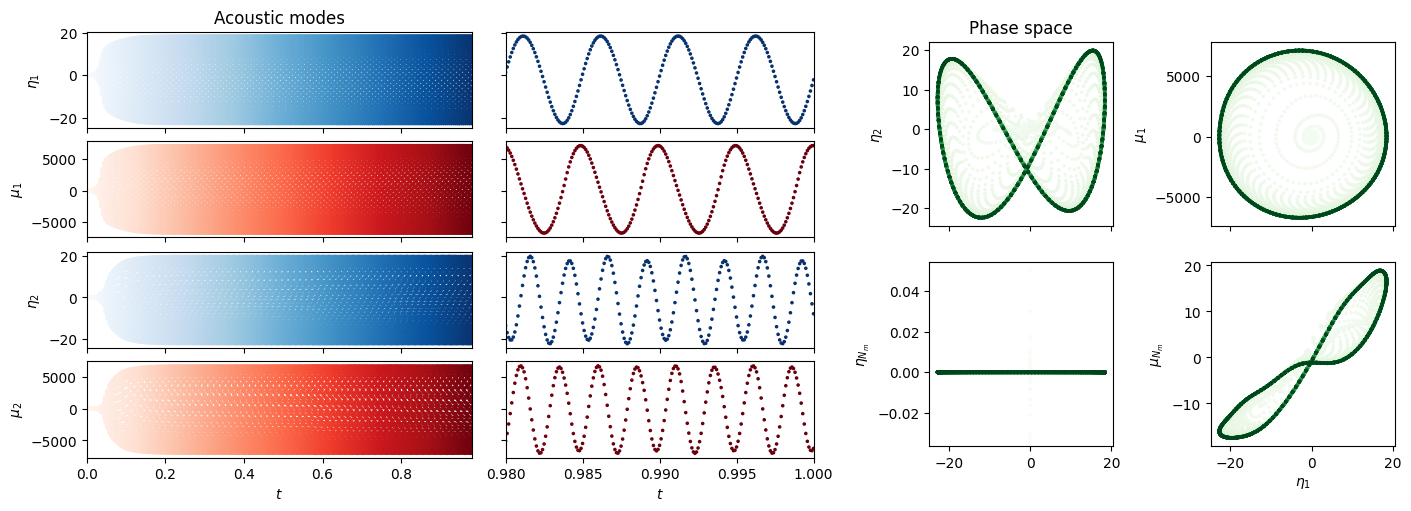

In [3]:
import matplotlib.pyplot as plt

fig1 = plt.figure(figsize=(14, 5), layout="constrained")
sub_fig1 = fig1.subfigures(1, 2, width_ratios=[1.5, 1])
axs = sub_fig1[0].subplots(4, 2, sharex='col', sharey='row', width_ratios=[1, 0.8])
Nt_zoom = int(case.t_CR / case.dt)
xlims = [[case.hist_t[0], case.hist_t[-1]-case.t_CR], [case.hist_t[-1]-case.t_CR, case.hist_t[-1]]]

lbls = ['$\eta_1$', '$\mu_1$', '$\eta_{2}$', '$\mu_{2}$']
cmaps = ['Blues', 'Reds', 'Blues', 'Reds']

for axs_, xl, tl in zip([axs[:, 0], axs[:, 1]], xlims, ['Acoustic modes', '']):
    
    for ii, ax, lbl, cmap in zip([0, case.Nm, 1, case.Nm+1], axs_, lbls, cmaps):
        ax.scatter(case.hist_t, case.hist[:, ii], c=case.hist_t, cmap=cmap, s=10, marker='.')
        if xl == xlims[0]:
            ax.set(ylabel=lbl)
            
    axs_[-1].set(xlabel='$t$', xlim=xl)
    axs_[0].set_title(tl)
    
axs = sub_fig1[1].subplots(2, 2, sharex='all')
axs = axs.ravel()
axs[0].set_title('Phase space')
for ii, ax, ylbl in zip([1, case.Nm, case.Nm-1, case.Nm*2], axs, ['$\eta_2$', '$\mu_1$', '$\eta_{N_m}$', '$\mu_{N_m}$']):
    ax.scatter(case.hist[:, 0], case.hist[:, ii], c=case.hist_t, cmap='Greens', s=10, marker='.')
    ax.set(ylabel=ylbl)
    if ii > case.Nm:
        ax.set(xlabel='$\eta_1$')
        
    ax.set_aspect(1. / ax.get_data_ratio())
plt.show()

## 3. Visualize acoustic pressure along the tube

The acoustic pressure at a location $x$ is computed as 
$$
p(\theta, t) = \sum_{j=0}^{N_m}\cos( \cos\theta + \eta_b(t) \sin\theta.
$$
The angle $\theta$ is defined such that $\theta=0^\circ$ corresponds to the bottom centre line of the combustor.

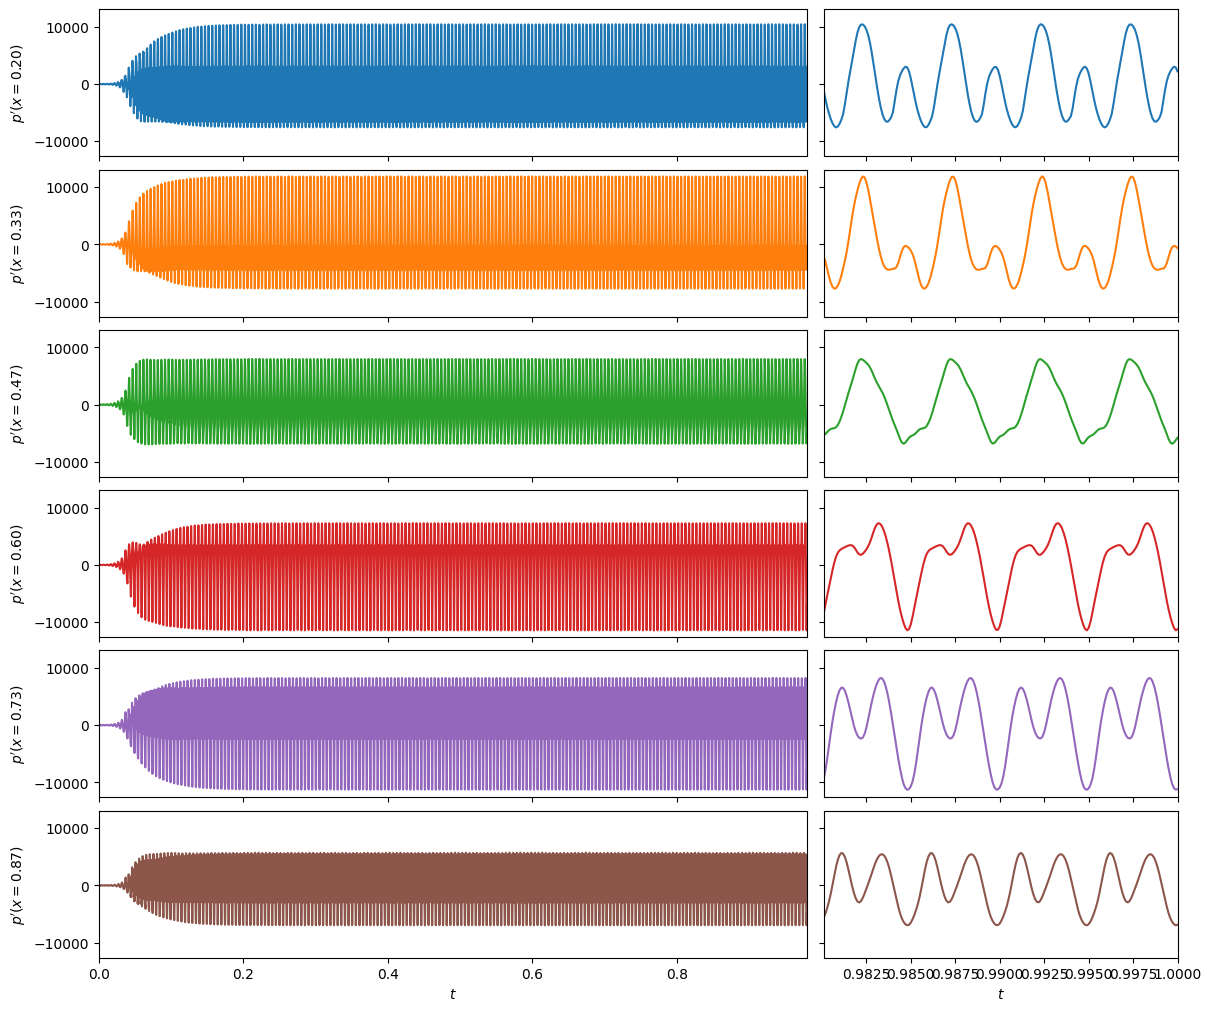

In [5]:

y = case.get_observable_hist()
lbl = case.obs_labels

fig1 = plt.figure(figsize=(12, 10), layout="constrained")
all_axs = fig1.subplots(case.Nq, 2, sharex='col', sharey=True, width_ratios=[2,1])
for axs, xl in zip([all_axs[:, 0], all_axs[:, 1]], [[0, -Nt_zoom], [-Nt_zoom, -1]]):
    for ax, ii, lbl in zip(axs, range(case.Nq), case.obs_labels):
        ax.plot(case.hist_t, y[:, ii], c='C{}'.format(ii))
        if xl[0] == 0:
            ax.set(ylabel=lbl)
    axs[-1].set(xlabel='$t$', xlim=[case.hist_t[xl[0]], case.hist_t[xl[-1]]])
    
        

We can also visualize the acoustic pressure in all the combustor as a video.

In [ ]:
from matplotlib.animation import FuncAnimation
import numpy as np
import os

folder = 'figs/TA_longitudinal/'
pressure_video_name = folder + 'Rijke.gif'


if not os.path.isfile(pressure_video_name):

    os.makedirs(folder, exist_ok=True)
    
    y = case.get_observable_hist()
    lbl = case.obs_labels
    
    fig1 = plt.figure(figsize=(12, 8), layout="constrained")
    sub_fig1 = fig1.subfigures(2, 1,  height_ratios=[0.5, 1. ])
    
    axs = sub_fig1[1].subplots(case.Nq//2, 2, sharey=True, sharex=True)
    axs = axs.ravel()
    for ax, ii, lbl in zip(axs, range(case.Nq), case.obs_labels):
        ax.set(ylabel=lbl)
    axs[-1].set(xlabel='$t$', xlim=[case.hist_t[0], case.hist_t[-1]])
    axs[0].set_title('Acoustic pressure');
    
    ax2 = sub_fig1[0].subplots(1, 1)
    
    xx = np.linspace(0, case.L, 200) 
    y_all = case.get_observable_hist(loc=xx).squeeze()
    
    yy = [0, 0.25]
    X, Y = np.meshgrid(xx / case.L, yy)
    
    ax2.set(yticklabels=[], title='Acoustic Pressure', xlabel='$x/L$')
    
    ax2.axvline(x=case.xf/case.L, color='k', ls='--', lw=3)


    idx_max = np.argmax(abs(y[:, 0]))

    lim = 10000
    contour_levels = 200
    Z_fake = np.ones(X.shape) * lim
    Z_fake[:, 0] *= -1
    cbar_mesh = ax2.contourf(X, Y, Z_fake,  cmap='RdBu', levels=contour_levels, vmin=-lim, vmax=lim)
    cbar = plt.colorbar(cbar_mesh, ax=ax2, label='Pressure', shrink=0.75, extend='both')
    tube_mesh = ax2.contourf(X, Y, [y_all[idx_max].T] * 2,  cmap='RdBu', levels=contour_levels, vmin=-lim, vmax=lim)

    
    start_i = int((case.hist_t[-1] - .01) // case.dt)
    t_gif = case.hist_t[start_i:]
    y_gif = y_all[start_i:]
    y = y[start_i:]
    t = case.hist_t[start_i:]
    axs[-1].set(xlim=[t_gif[0], t_gif[-1]])
    
    def update(frame):
        ax2.clear()
        for ax, ii, lbl in zip(axs, np.arange(case.Nq), case.obs_labels):
            ax.plot(t[:frame+1], y[:frame+1, ii], c='C{}'.format(ii), lw=2)
            ax.set(ylabel=lbl)

        tube_mesh = ax2.contourf(X, Y, [y_gif[frame+1].T] * 2,  cmap='RdBu', levels=contour_levels, vmin=-lim, vmax=lim)
        ax2.axvline(x=case.xf/case.L, color='k', ls='--', lw=3)
        ax2.set_title('Acoustic Pressure $t$ = {:.3f}'.format(t_gif[frame+1]))  
    
    anim = FuncAnimation(fig1, update,  frames=np.arange(len(t_gif)-1))
    anim.save(pressure_video_name, fps=10, writer='pillow')
    plt.close()
    


In [ ]:
from IPython.display import Markdown as md

md(f"<img src={pressure_video_name}>")